In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#load dataset... features parquet
#df = pd.read_parquet("../data/processed/hex_features.parquet")

#retraining model with improved dataset. population added
#df = pd.read_parquet("../data/processed/hex_with_population.parquet")

#retraining dataset with more improvement. travel time added
df = pd.read_parquet("../data/processed/hex_with_travel_time.parquet")

#dropping NaNs for travel time
df = df.dropna(subset=['travel_time_min'])


#load originals hexes with geometry for visualization later
hex_grid = gpd.read_parquet("../data/processed/hex_features.parquet")

In [82]:
#select features and target
#features = ['road_density', 'hospital_count', 'dist_to_center']

#updating parameters after improving data
#features = ['road_density', 'hospital_count', 'dist_to_center', 'population']

#updating parameters after improving data
features = ['road_density', 'hospital_count', 'dist_to_center', 'population', 'travel_time_min']

#updating parameters after improving data with travel time as target
#features = ['road_density', 'hospital_count', 'dist_to_center', 'population']

target = 'dist_to_hospital_m'

#change target from distance to travel time
#target = 'travel_time_min'

#In machine learning: X (capital X) represents the input features u used to make predictions. 
#y (lowercase y) is the target/output. the prediction
X = df[features]
y = df[target]

In [84]:
df.corr(numeric_only=True)

,dist_to_hospital_deg,dist_to_hospital_m,road_density,hospital_count,dist_to_center,populatiom,population,travel_time_min
dist_to_hospital_deg,1.000000,1.000000,-0.584578,-0.279560,0.415771,-0.576030,-0.576030,0.750298
dist_to_hospital_m,1.000000,1.000000,-0.584578,-0.279560,0.415771,-0.576030,-0.576030,0.750298
road_density,-0.584578,-0.584578,1.000000,0.392789,0.127175,0.915430,0.915430,-0.503131
hospital_count,-0.279560,-0.279560,0.392789,1.000000,-0.039340,0.298904,0.298904,-0.325377
dist_to_center,0.415771,0.415771,0.127175,-0.039340,1.000000,0.225054,0.225054,0.202913
populatiom,-0.576030,-0.576030,0.915430,0.298904,0.225054,1.000000,1.000000,-0.477276
population,-0.576030,-0.576030,0.915430,0.298904,0.225054,1.000000,1.000000,-0.477276
travel_time_min,0.750298,0.750298,-0.503131,-0.325377,0.202913,-0.477276,-0.477276,1.000000


In [86]:
#train and test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"    RMSE: {rmse:.2f} meters")
print(f"R² Score: {r2:.3f}")

    RMSE: 1943.53 meters
R² Score: 0.945


In [26]:
X_full = df[features]
X_full

,road_density,hospital_count,dist_to_center,population,travel_time_min
0,0.000000,0,21699.821389,0.000000,19.371198
1,0.000000,0,21615.835565,0.000000,19.371198
2,0.000000,0,21540.258827,0.000000,19.371198
3,0.000000,0,21473.179933,0.000000,19.371198
4,0.000000,0,21414.678708,0.000000,19.371198
...,...,...,...,...,...
4785,150.094764,0,23783.273138,10.140399,34.717531
4786,850.806627,0,23996.074523,17.381500,34.717531
4787,433.654588,0,24214.687273,23.718884,34.717531
4788,612.333122,0,24438.955411,29.781738,34.717531


In [ ]:
df['predicted'] = model.predict(X_full)
df['geometry'] = df['geometry'].apply(wkb.loads)

df = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:3857")

df.to_parquet("../data/processed/hex_with_predictions.parquet")

In [272]:
features


['road_density',
 'hospital_count',
 'dist_to_center',
 'population',
 'travel_time_min']

In [274]:
X_train.head()
y_train.head()


90      24349.486564
3521     1470.429730
4789    26500.909571
1362    16916.816555
4480    20095.564103
Name: dist_to_hospital_m, dtype: float64

In [276]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(3816, 5) (954, 8)
(3816,) (954,)


In [ ]:
joblib.dump(model, "../models/hospital_access_model.joblib")

['../models/hospital_access_model.joblib']

In [ ]:
X_test['predicted'] = y_pred
X_test['actual'] = y_test
X_test['error'] = X_test['predicted'] - X_test['actual']


In [ ]:
hex_viz = hex_grid.copy()
hex_viz = hex_viz.join(X_test[['predicted', 'actual', 'error']], how='left')

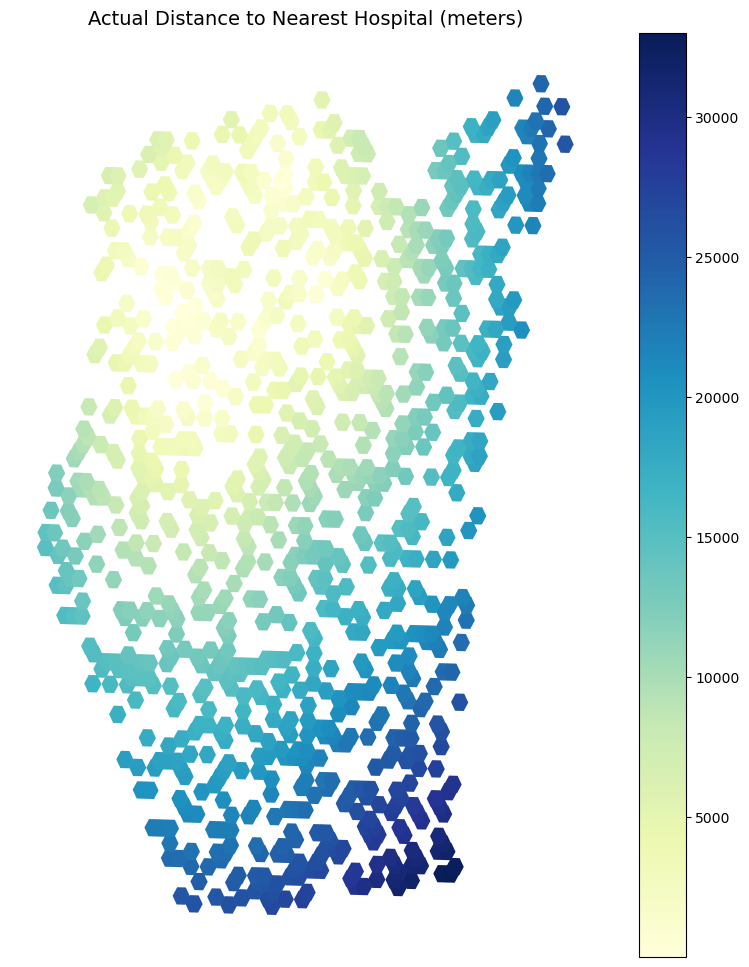

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
hex_viz.plot(column='actual', cmap='YlGnBu', legend=True, ax=ax)
ax.set_title("Actual Distance to Nearest Hospital (meters)", fontsize=14)
ax.axis('off')
plt.show()

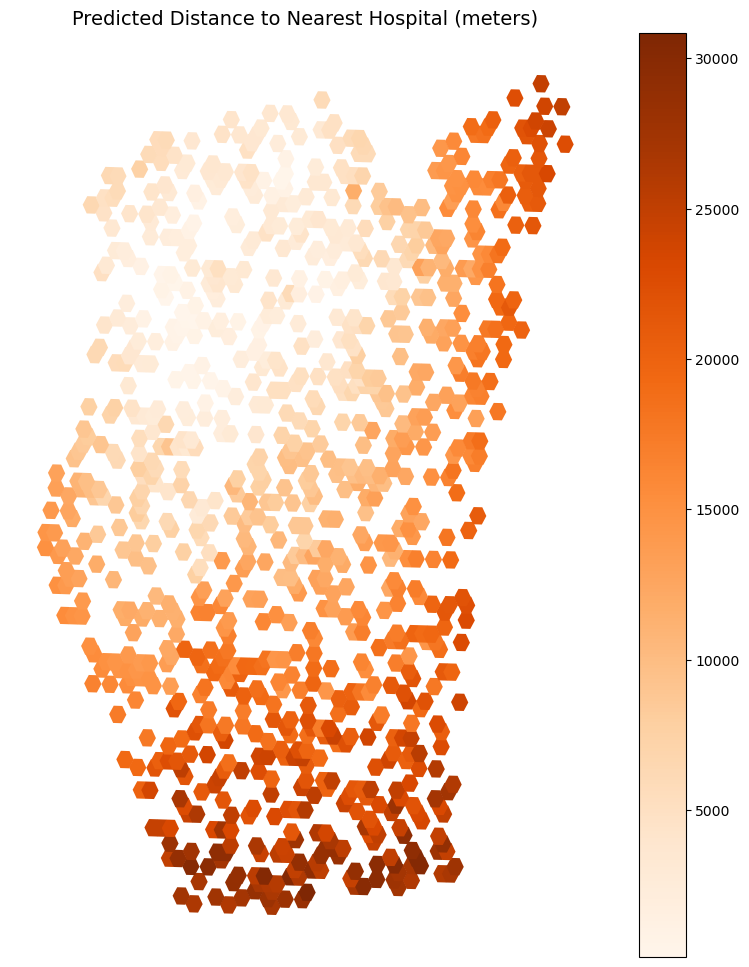

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
hex_viz.plot(column='predicted', cmap='Oranges', legend=True, ax=ax)
ax.set_title("Predicted Distance to Nearest Hospital (meters)", fontsize=14)
ax.axis('off')
plt.show()


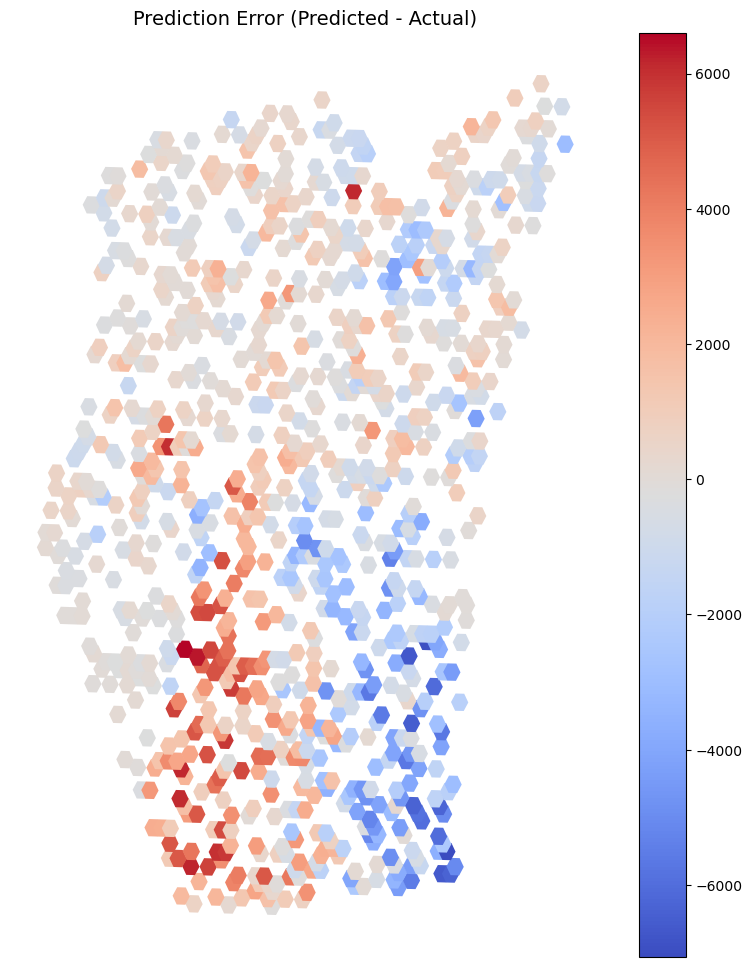

In [181]:
fig, ax = plt.subplots(figsize=(10, 12))
hex_viz.plot(column='error', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Prediction Error (Predicted - Actual)", fontsize=14)
ax.axis('off')
plt.show()

In [116]:
type(hex_viz)


geopandas.geodataframe.GeoDataFrame

In [ ]:
joblib.dump(model, "../models/hospital_access_model.joblib")

['../models/hospital_access_model.joblib']